In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.wkt import loads

from mapboxgl.utils import create_color_stops, create_weight_stops
from mapboxgl.viz import ChoroplethViz, HeatmapViz
from jenkspy import jenks_breaks
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import psycopg2 as pg
import pandas.io.sql as psql

from tqdm import tqdm_notebook as tqdm
%matplotlib inline

## NYC Yellow Taxi data test task

Let's take a first glance at the data:

In [2]:
! wc -l data/yellow_tripdata_2015.csv # number of rows

 69006888 data/yellow_tripdata_2015.csv


In [3]:
! head data/yellow_tripdata_2015.csv 

,tpep_pickup_datetime,pickup_longitude,pickup_latitude
0,2015-07-01 00:00:00,-73.99415588378906,40.75112533569336
1,2015-07-01 00:00:00,-73.98465728759766,40.76848602294922
2,2015-07-01 00:00:00,-73.97888946533203,40.76228713989258
3,2015-07-01 00:00:00,-73.99279022216798,40.742759704589844
4,2015-07-01 00:00:00,-73.9124298095703,40.76980972290039
5,2015-07-01 00:00:00,-73.95915985107422,40.77342987060547
6,2015-07-01 00:00:00,-73.78945922851562,40.64725875854492
7,2015-07-01 00:00:00,0.0,0.0
8,2015-07-01 00:00:00,-73.99893188476562,40.74467849731445


Let's map a small sample of points to get some basic idea about spatial distribution.

In [4]:
df = pd.read_csv('data/yellow_tripdata_2015.csv', nrows=10000)

In [5]:
# filter invalid coodrinates
df = df[df['pickup_longitude'] < -70.0].reset_index(drop=True)

# make GeoDataFrame with shapely geometries
df['geometry'] = [Point(x,y) for x,y in zip(df['pickup_longitude'], df['pickup_latitude'])] 
df = gpd.GeoDataFrame(df)

# export data to geojson to use with mapbox
with open('data/sample_pnts.geojson','w') as f:
    f.write(df.to_json())

In [6]:
df.head(2)

,Unnamed: 0,tpep_pickup_datetime,pickup_longitude,pickup_latitude,geometry
0,0,2015-07-01 00:00:00,-73.994156,40.751125,POINT (-73.99415588378906 40.75112533569336)
1,1,2015-07-01 00:00:00,-73.984657,40.768486,POINT (-73.98465728759766 40.76848602294922)


In [7]:
# mapbox access token
token = 'pk.eyJ1IjoiZ2VvdHl1a2F2aW4iLCJhIjoiY2l3YzFrcGF2MDA0czJ5cTdtbWYxY3hoOSJ9.27RqchNskV797X9k_SG0BQ'

# creating parameters for a heatmap
color_stops = [0.01,0.25,0.5,0.75,1]
heatmap_color_stops = create_color_stops(color_stops, colors='RdPu')
heatmap_radius_stops = [[0,0.5], [1, 3]] #increase radius with zoom
heatmap_weight_stops = create_weight_stops(color_stops)

#Create a heatmap
viz = HeatmapViz('data/sample_pnts.geojson',
                  access_token=token,
                  weight_property='count',
                  weight_stops=heatmap_weight_stops,
                  color_stops=heatmap_color_stops,
                  radius_stops=heatmap_radius_stops,
                  opacity=0.9,
                  center = MultiPoint(df['geometry'].tolist()).centroid.coords[0],
                  zoom=11,
                  below_layer='waterway-label')
viz.show()

We can already see that taxi trips are mostly concentrated in Manhattan and airports.

## Trip statistics by zone

For this part I took official taxi zones used by the City of New York from [the official NYC webcite](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) (the only preprocessing i did was reprojecting to Lat/Lon WGS 84 to match the trip data and converting to `.geojson` because shapefiles are ugly).

In [8]:
zones = gpd.read_file('data/taxi_zones.geojson')
zones.head(2)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"(POLYGON ((-74.184453 40.6949959999999, -74.18..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260664 40.6389870471767...


Intersecting big amounts of point data with complex shaped polygons takes a lot of computation, so I needed to chunk the dataset.  
  
Using a regular rectangular fishnet could have decreased the computation but official taxi zones seemed more elegant to me.  

This process took approx 2 hours (while waiting I implemented a PosgreSQL-based way to process data, that I'll show later this notebook)

In [ ]:
zones = gpd.read_file('taxi_zones.geojson')
zones = zones[['OBJECTID', 'zone', 'geometry']]
zones['count'] = 0

# the optimal chunk size was found empirically based on tqdm's estimations
chunksize = 100000

for df in tqdm(pd.read_csv('data/yellow_tripdata_2015.csv', chunksize=chunksize, usecols=['pickup_longitude', 'pickup_latitude']), total=round(69006888/chunksize)):
    
    # transforming data to geodataframe, setting a projection
    df['geometry'] = [Point(x,y) for x,y in zip(df['pickup_longitude'], df['pickup_latitude'])]
    df = df.drop(columns=['pickup_longitude','pickup_latitude'])
    df = gpd.GeoDataFrame(df)
    df.crs = {'init': 'epsg:4326'}
    
    # joining trips and zones spatially, counting points in each zone
    sp_joined = gpd.sjoin(
    df, zones, how='left').groupby('OBJECTID', as_index=False).count()[['OBJECTID', 'index_right']]
    sp_joined = sp_joined.rename(columns={'index_right':'count'})
    zones = pd.merge(zones, sp_joined, on='OBJECTID', how='outer')
    
    # a little hacky way to store trip counts over iterations
    zones = zones.fillna(0)
    zones['count'] = zones['count_y'] + zones['count_x']
    zones = zones[['OBJECTID', 'zone', 'count', 'geometry']]
    
del df

In [9]:
# export data to geojson

#with open('data/zones_with_counts.geojson','w') as f:
#    f.write(zones.to_json(ensure_ascii=False))

In [10]:
zones = gpd.read_file('data/zones_with_counts.geojson')

In [11]:
print(str(round(((
    69006888 - zones['count'].sum()) / 69006888), 3) * 100)+ '% of data was filtered due to invalid coordinates')

1.5% of data was filtered due to invalid coordinates


In [12]:
zones.head(2)

,id,OBJECTID,count,zone,geometry
0,0,1,4607.0,Newark Airport,"(POLYGON ((-74.184453 40.6949959999999, -74.18..."
1,1,2,40.0,Jamaica Bay,(POLYGON ((-73.82337597260664 40.6389870471767...


Let's make a choropleth map ([Here](https://andreytyu.github.io/taxi-test/viz/) you can find a small JavaScript version ov this visualization)

In [13]:
# genetate breaks based on the data distribution
color_breaks = jenks_breaks(zones['count'], nb_class=5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = ChoroplethViz('data/zones_with_counts.geojson',
                    line_width = 0.8,
                access_token=token,
                height='400px',
                color_property = "count",
                color_stops = color_stops,
                center = (-73.97, 40.74),
                zoom = 10,
                opacity=0.6,
                below_layer = 'waterway-label'
              )
viz.show()

In [14]:
zones.sort_values(by='count', ascending=False).head()

,id,OBJECTID,count,zone,geometry
236,236,237,2500998.0,Upper East Side South,(POLYGON ((-73.96612747299991 40.7621792999999...
160,160,161,2408518.0,Midtown Center,(POLYGON ((-73.97534377999995 40.7552996949999...
185,185,186,2298132.0,Penn Station/Madison Sq West,(POLYGON ((-73.99096832799997 40.7454208899998...
78,78,79,2277173.0,East Village,(POLYGON ((-73.98377990999992 40.7215359539999...
233,233,234,2262147.0,Union Sq,(POLYGON ((-73.9899693639999 40.73490456699995...


The most polular zone is Upper East Side South, let's generate timeseries data for it.

## Generating timeseries

First we need to filter needed trips from the dataset.

In [15]:
# getting the desired zone's bounding box
my_zone = zones.sort_values(by='count', ascending=False).reset_index(drop=True)['geometry'][0]
my_zone_bbox = my_zone.bounds

In [17]:
# discarding the points that are not within the polygon's bbox to decrease further computation
chunksize = 100000
in_my_zone = pd.DataFrame()

for df in tqdm(pd.read_csv('data/yellow_tripdata_2015.csv', chunksize=chunksize, usecols=['tpep_pickup_datetime','pickup_longitude', 'pickup_latitude']), total=round(69006888/chunksize)):
    
    df = df[
        (df['pickup_longitude'] >= my_zone_bbox[0])
        &(df['pickup_longitude'] <= my_zone_bbox[2])
        &(df['pickup_latitude'] >= my_zone_bbox[1])
        &(df['pickup_latitude'] <= my_zone_bbox[3])
    ].reset_index(drop=True)
    
    in_my_zone = pd.concat([in_my_zone, df], ignore_index=True)

In [18]:
in_my_zone['geometry'] = [Point(x,y) for x,y in zip(in_my_zone['pickup_longitude'], in_my_zone['pickup_latitude'])]
in_my_zone = in_my_zone[['tpep_pickup_datetime', 'geometry']]
in_my_zone = gpd.GeoDataFrame(in_my_zone)

In [19]:
len(in_my_zone)

4250493

Intersecting the rest of the points with the actual polygon to discard unwanted ones. This could have been done without a loop with ```points.intersection(polygon)```, but with this amount of data I wanted to know estimated time

In [20]:
bool_filter = []
for x in tqdm(range(len(in_my_zone))):
    bool_filter.append(in_my_zone['geometry'][x].intersects(my_zone))

In [21]:
in_my_zone = in_my_zone[bool_filter].reset_index(drop=True)
in_my_zone['id'] = range(len(in_my_zone))
len(in_my_zone)

2500998

In [22]:
# export data to geojson

#with open('data/trips_needed.geojson','w') as f:
#    f.write(in_my_zone.to_json())

In [23]:
in_my_zone = gpd.read_file('data/trips_needed.geojson')

In [24]:
in_my_zone.head(2)

,id,tpep_pickup_datetime,geometry
0,0,2015-07-01T00:00:00,POINT (-73.96221923828125 40.77333831787109)
1,1,2015-07-01T00:00:07,POINT (-73.96724700927734 40.76663208007813)


In [25]:
# aggregating data by hours
in_my_zone['tpep_pickup_datetime'] = pd.to_datetime(in_my_zone['tpep_pickup_datetime'])
in_my_zone['tpep_pickup_datetime_new'] = in_my_zone['tpep_pickup_datetime'].dt.round('1H')  
data_agg = in_my_zone.groupby(by='tpep_pickup_datetime_new').count()[['id']]
data_agg = data_agg.rename(columns={'id':'trip_count'})
del in_my_zone

In [26]:
data_agg.head(3)

,trip_count
tpep_pickup_datetime_new,
2015-07-01 00:00:00,117
2015-07-01 01:00:00,146
2015-07-01 02:00:00,67


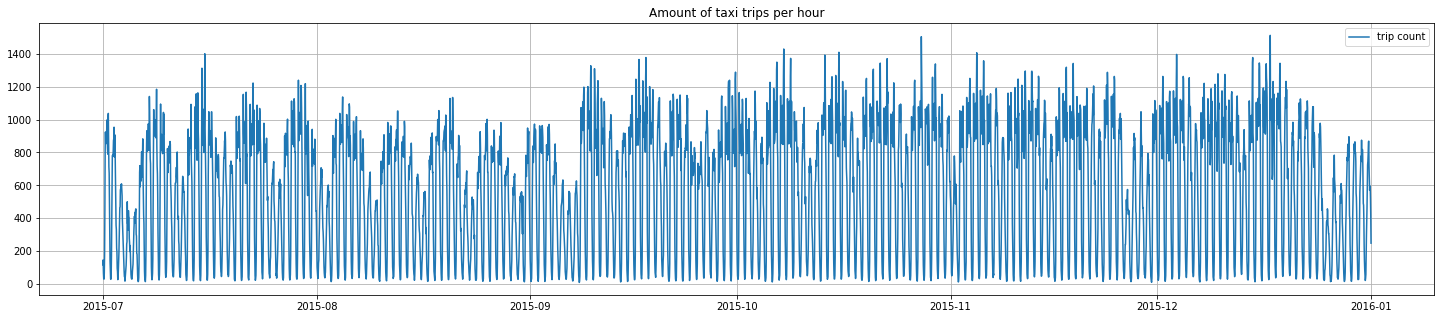

In [27]:
plt.figure(figsize=(25, 5))
plt.plot(data_agg.trip_count, label="trip count")
plt.legend(loc="best")
plt.title("Amount of taxi trips per hour")
plt.grid(True)

## SQL approach

For this task I used a PosrgeSQL/PosGIS database. [Here](https://github.com/andreytyu/taxi-test/blob/master/sql) you can find instructions on how to start a postgres instance with Docker, connect to it and process the data.

Unfortunately I ran out of memory at the last steps of processing the data, so I took just a sample of one million points to showcase this approach. I think this is the way I would store and process the data in real life using a more powerful server.

In [28]:
# connect to the db
connection = pg.connect(
        host='localhost',
        port='9900', dbname='postgres', 
        user='postgres',
        password='password') 
# query data as DataFrames
zones_agg = psql.read_sql_query(
        """select zone_id, zone_name, count, st_astext(geom) as geom from zones_agg""",
        connection)
hour_agg = psql.read_sql_query(
        """select * from hour_agg""",
        connection)
connection.close() 

In [29]:
zones_agg.sort_values(by='count', ascending=False).head(2)

,zone_id,zone_name,count,geom
170,161.0,Midtown Center,37262,MULTIPOLYGON(((-73.9753437799999 40.7552996949...
239,237.0,Upper East Side South,34471,MULTIPOLYGON(((-73.9661274729999 40.7621792999...


In this subset of data Midtown Center has more trips than Upper East Side South, but still, the result looks pretty much the same

In [30]:
# converting geometries from Well-Known Text, exporting geojson
zones_agg['geometry'] = [loads(x) for x in zones_agg['geom']]
zones_agg = zones_agg.drop('geom', axis=1)
zones_agg = gpd.GeoDataFrame(zones_agg)
with open('data/zones_agg_from_sql.geojson','w') as f:
    f.write(zones_agg.to_json())

In [31]:
color_breaks = jenks_breaks(zones_agg['count'], nb_class=5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = ChoroplethViz('data/zones_agg_from_sql.geojson',
                    line_width = 0.8,
                access_token=token,
                height='400px',
                color_property = "count",
                color_stops = color_stops,
                center = (-73.97, 40.74),
                zoom = 10,
                opacity=0.6,
                below_layer = 'waterway-label'
              )
viz.show()

In [32]:
hour_agg.index = pd.DatetimeIndex(hour_agg.dt)
hour_agg = hour_agg.drop('dt', axis=1)
hour_agg.head(5)

,count
dt,
2015-07-01 00:00:00,509
2015-07-01 01:00:00,253
2015-07-01 02:00:00,120
2015-07-01 03:00:00,77
2015-07-01 04:00:00,52


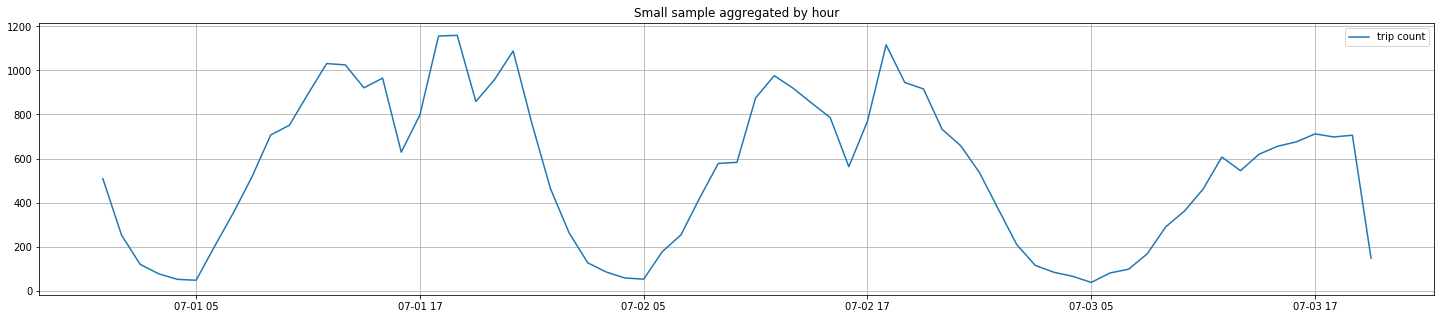

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(hour_agg['count'], label="trip count")
plt.legend(loc="best")
plt.title("Small sample aggregated by hour")
plt.grid(True)

## Baseline

Let's assume that tomorrow's amount of trips will be the same as today's:

In [34]:
def predict_one_hour_forward(series):
    actual = series.drop(index=series.index[0])
    prediction = series.shift(1).dropna()
    return actual, prediction

base_actual, base_prediction = predict_one_hour_forward(data_agg.trip_count)

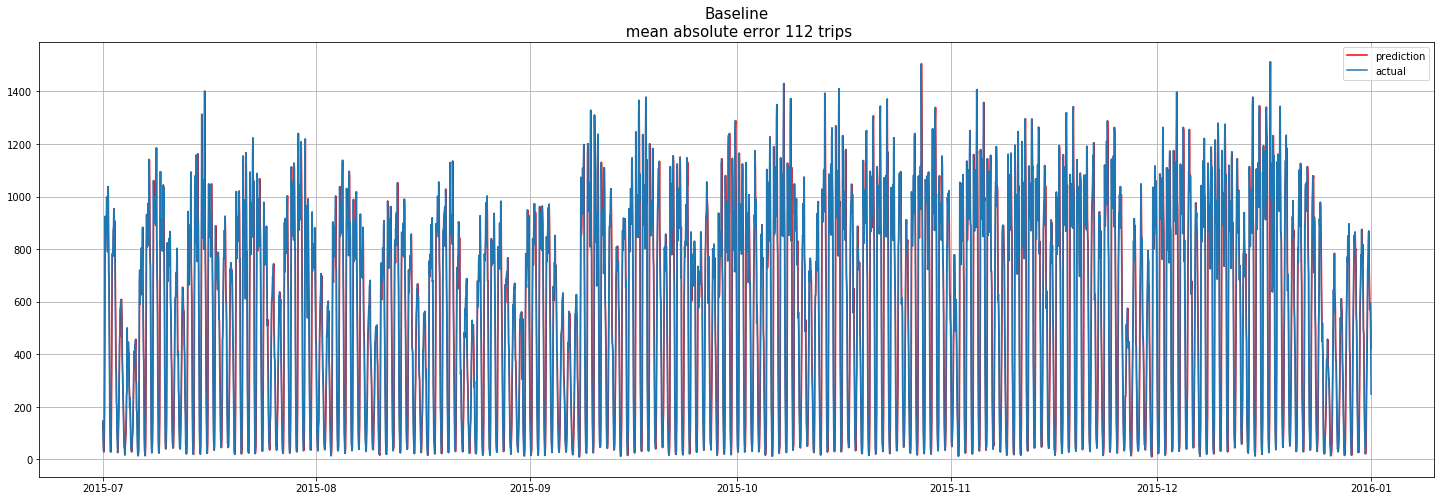

In [35]:
plt.figure(figsize=(25, 8))
plt.plot(base_prediction, "r", label="prediction")
plt.plot(base_actual, label="actual")
plt.legend(loc="best")
plt.title("Baseline\n mean absolute error %i trips"%(int(
    mean_absolute_error(base_actual,
                        base_prediction))),size=15)
plt.grid(True)

Predicting trip count based on the previous value shows the mean absolute error of 112 trips.

Let's try to beat this score with a linear model.

## Data exploration and feature construction

#### Date and time features

In [36]:
# extracting day of week and hour from DateTimeIndex
data_agg['dow'] = data_agg.index.dayofweek
data_agg['hour'] = data_agg.index.hour

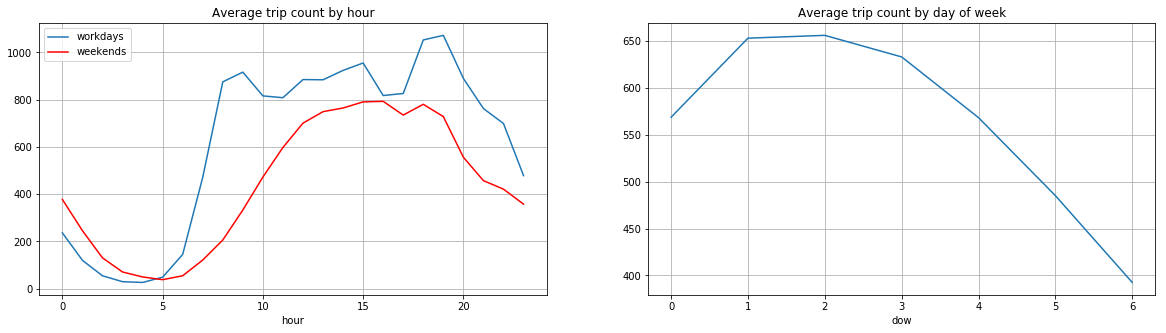

In [37]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Average trip count by hour")

# Plotting average counts by hour for workdays and days off
data_agg[data_agg.dow.isin([5,6]) == False].groupby('hour').trip_count.mean().plot(label='workdays')
data_agg[data_agg.dow.isin([5,6])].groupby('hour').trip_count.mean().plot(color='r', label='weekends')

plt.legend(loc="upper left")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title("Average trip count by day of week")

# Plotting average counts by day of week
data_agg.groupby('dow').trip_count.mean().plot()
plt.grid(True)

We can see that the hour of the day matters, as well as the day of week. Workdays have two peaks – morning and evening, weekends are much smoother.

Besides weekends there's a number of [federal and state holidays in NYC](https://www.officeholidays.com/countries/usa/regional.php?list_year=2015&list_region=New%20York). Let's add them to the features.

In [38]:
holidays_df = pd.read_csv('data/nyc_holidays.csv', sep=';')
nyc_holidays = pd.to_datetime(holidays_df.date)
nyc_holidays = [x.date() for x in nyc_holidays]
holidays_df

,date,holiday,commentary
0,2015-07-03,Independence Day (observed),Friday is a holiday as 4th July is on a Saturday
1,2015-09-07,Labor Day,First Monday in September
2,2015-10-12,Columbus Day,2nd Monday in October
3,2015-11-11,Veterans Day,Federal holiday. Only observed by 20% of priva...
4,2015-11-26,Thanksgiving,Fourth Thursday in November
5,2015-11-27,Day after Thanksgiving,Day after 4th Thursday in November
6,2015-12-25,Christmas Day,NaN


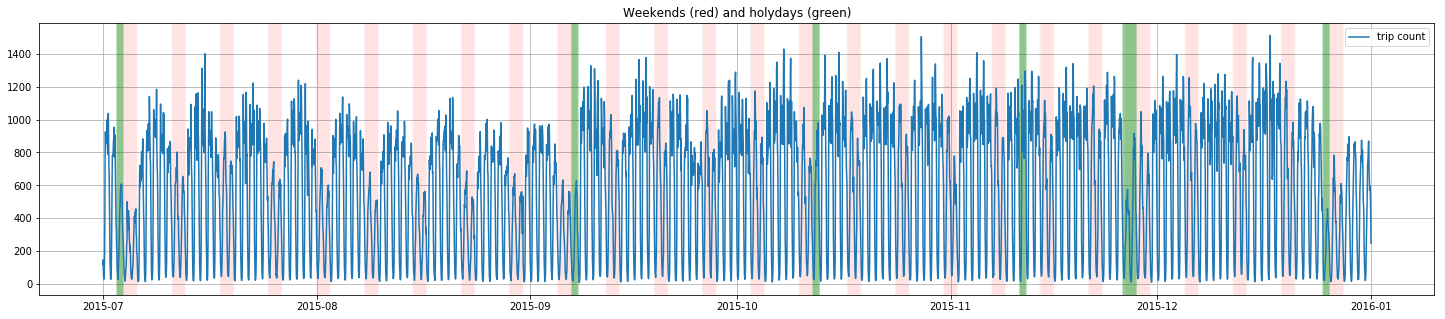

In [39]:
data_agg["date"] = data_agg.index.date
plt.figure(figsize=(25, 5))

for x in data_agg[data_agg.dow.isin([5,6])].index:
    plt.axvline(x, color='red', alpha=0.02)
    
for x in data_agg[data_agg.date.isin(nyc_holidays)].index:
    plt.axvline(x, color='green', alpha=0.1)
    
plt.plot(data_agg.trip_count, label="trip count")
plt.legend(loc="best")
plt.title("Weekends (red) and holydays (green)")

plt.grid(True)

We can see that all holidays lead to drops in trip amounts, except Veterans Day which is "only observed by 20% of private business" according to the commentary in the dataset. It might be a good idea to drop it.

In [40]:
holidays_df = holidays_df[holidays_df.holiday != 'Veterans Day']
nyc_holidays = pd.to_datetime(holidays_df.date)
nyc_holidays = [x.date() for x in nyc_holidays]

#### Weather conditions

It is well known that weather conditions, especially rain, affect the number of taxi rides. Let's use [this dataset from Kaggle](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#weather_description.csv) to mock the forecast data.

In [41]:
weather = pd.read_csv('data/weather_description.csv', parse_dates=['datetime'])
weather = weather[['datetime', 'New York']]
weather.head(5)

,datetime,New York
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,few clouds
2,2012-10-01 14:00:00,few clouds
3,2012-10-01 15:00:00,few clouds
4,2012-10-01 16:00:00,few clouds


In [42]:
weather['year'] = weather.datetime.dt.year
weather = weather[weather.year == 2015].reset_index(drop=True)

# mark rainy days in the dataset (at first I aslo selected drizzle, but then dropped it)
weather['is_rainy'] = [('rain' in x)|('thunderstorm' in x)*1 for x in weather['New York']]
weather.index = weather.datetime
weather = weather[['is_rainy']]

# creating a dictionary to map the weather data on our timeseries
rainy_hours = pd.merge(data_agg, weather, left_index=True, right_index=True)['is_rainy'].to_dict()

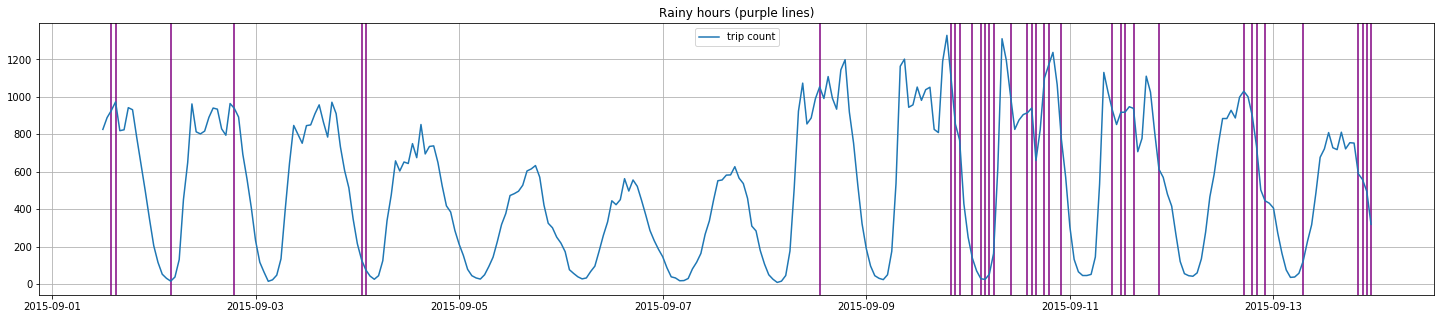

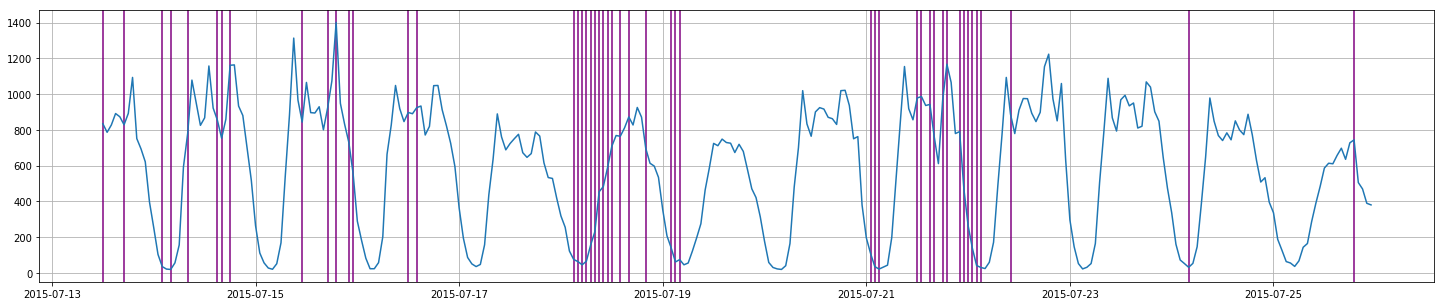

In [43]:
# plotting two parts of the time series to see the effect of rain on the data

rain_test = pd.merge(data_agg, weather, left_index=True, right_index=True)['is_rainy']

plt.figure(figsize=(25, 5))
for x in rain_test[1500:1800][rain_test[1500:1800] == 1].index:
    plt.axvline(x, color='purple')
plt.plot(data_agg.trip_count[1500:1800], label="trip count")
plt.legend(loc="best")
plt.title("Rainy hours (purple lines)")
plt.grid(True)

plt.figure(figsize=(25, 5))
for x in rain_test[300:600][rain_test[300:600] == 1].index:
    plt.axvline(x, color='purple')
plt.plot(data_agg.trip_count[300:600], label="trip count")
plt.grid(True)

Compare two Sundays: dry July 18 with a peak of approx 600 trips and rainy September 6 with 900

#### Preparing the data

In [44]:
def code_mean(data, cat_feature, real_feature):
    """
        Encode a categorial feature with it's mean value
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [45]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [46]:
def prepare_data(series, lags, test_size):
    """
        Add time lags, days off, weather data,
        encode hour and day of week, perform split
    """
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ['y']
    
    # lags of series
    for lag_val in lags:
        data["lag_%i"%(lag_val)] = data.y.shift(lag_val)
    
    # create temporary fields
    data['hour'] = data.index.hour
    data['date'] = data.index.date
    data['dow'] = data.index.dayofweek
    
    # combine weekends and holidays
    data['is_day_off'] = data.dow.isin([5,6])*1 + data.date.isin(nyc_holidays)*1
    # as long as I want to use 24 lags, it might be a good idea to give the model
    data['was_yesterday_day_off'] = data['is_day_off'].shift(24)
    
    # in real life it would be possible to use forecast data
    # I'm not sure I want to give the model the actual weather conditions for the hour,
    # so let's assume that rain in the previous hour increases the chance of rain for the next one
    data["is_it_rainy"] = data.index.map(rainy_hours)
    data["was_it_rainy"] = data["is_it_rainy"]#.shift(1)    
    
    # encode hours and weekdays as their mean value (only for the train part)
    test_index = int(len(data.dropna())*(1-test_size)) 
    data['weekday_average'] = data.dow.map(code_mean(data[:test_index], 'dow', 'y'))
    data["hour_average"] = data.hour.map(code_mean(data[:test_index], 'hour', 'y'))
    
    # drop unneeded stuff
    data.drop(['hour', 'dow','date','is_it_rainy'], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test


In [47]:
def plot_model_results(model, X_train, X_test):
    """
        Plots modelled vs fact values
    """
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(25, 7))
    plt.plot(prediction, 'r', label='prediction', linewidth=1.0)
    plt.plot(y_test.values, label='actual', linewidth=1.0)

    error = mean_absolute_error(prediction, y_test)
    plt.title('Mean absolute error %i'%(int(error)),size=15)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    
def plot_coefficients(model):
    """
        Plots sorted coefficient (feature importances) values of the model
    """
    try:
        coefs = pd.DataFrame(model.coef_, X_train.columns)
    except:
        coefs = pd.DataFrame(model.feature_importances_, X_train.columns)
        
    # sorting by absolute value
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(25, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

## Modelling

#### Linear model

In [48]:
lags = range(1,25) # we'll generate lags for past 24 hours
test_size = 0.3

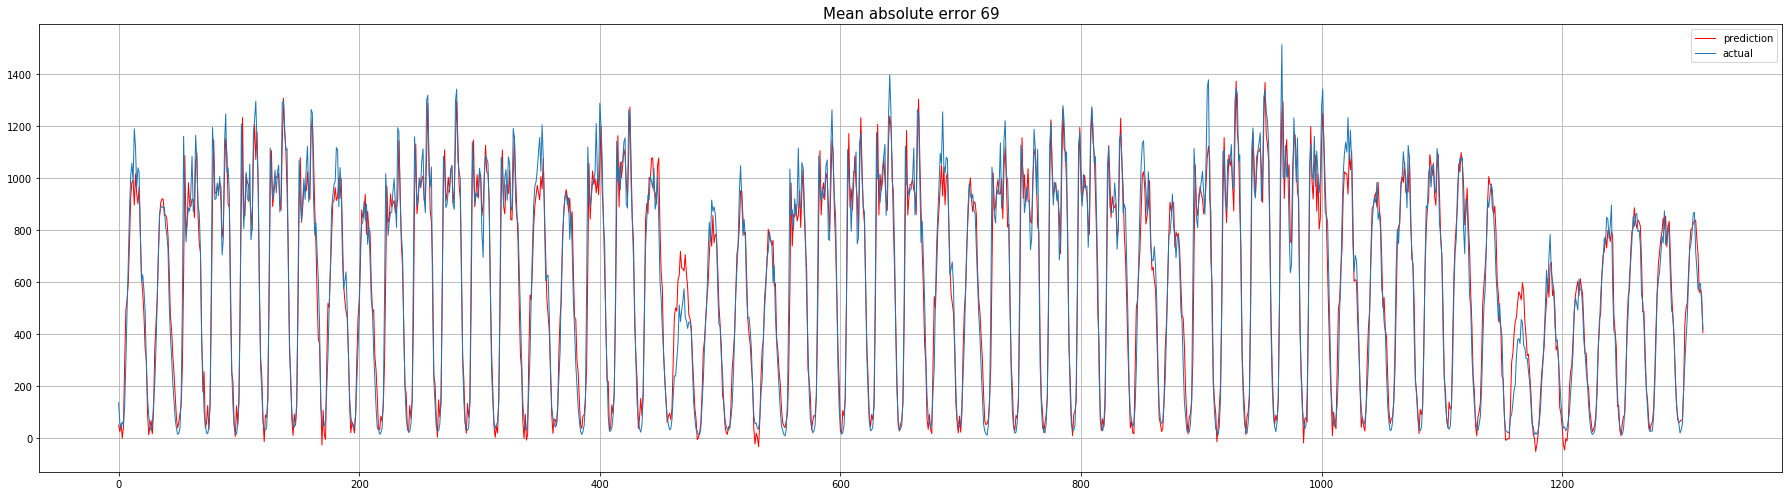

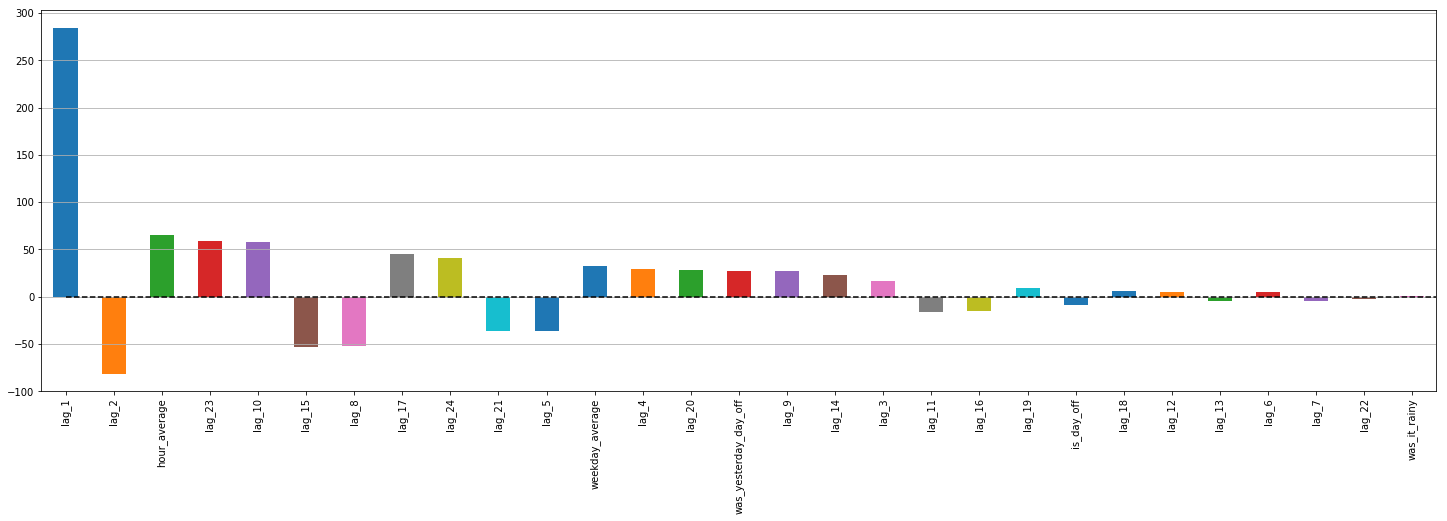

In [49]:
X_train, X_test, y_train, y_test = prepare_data(data_agg.trip_count, lags = range(1,25), test_size = 0.3)

# scale the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plot_model_results(lr, X_train=X_train_scaled, X_test=X_test_scaled)
plot_coefficients(lr)

#### Gradient boosting

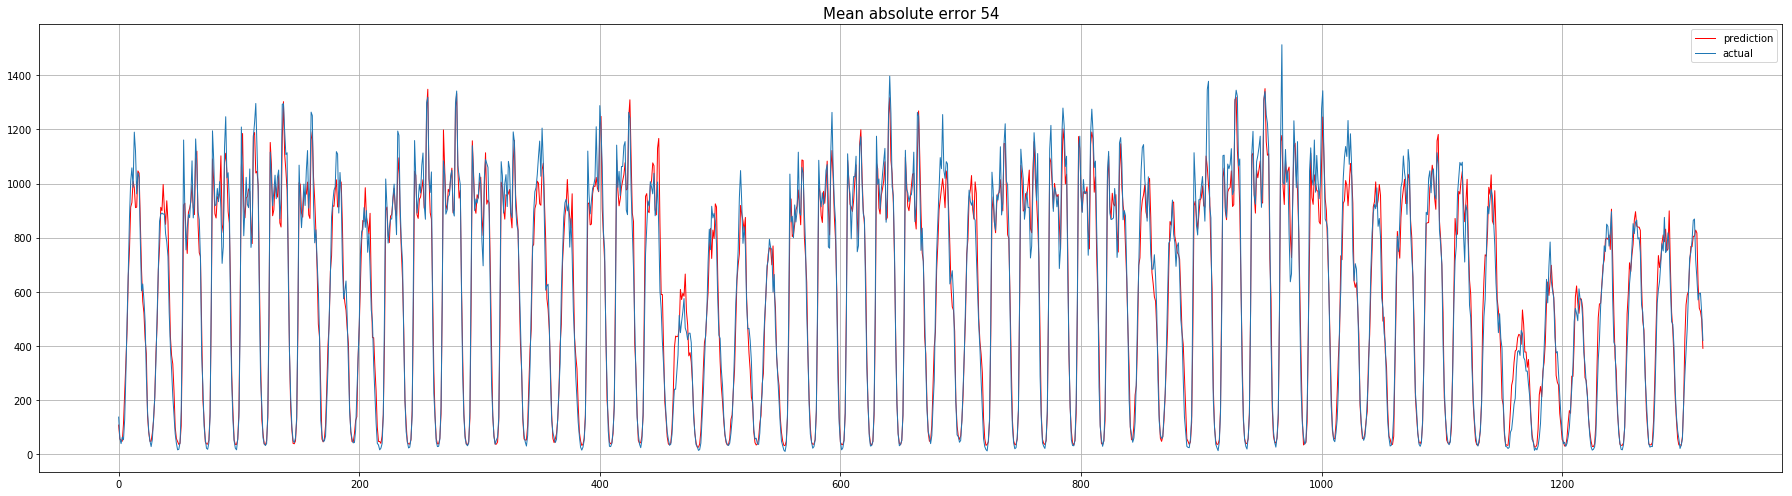

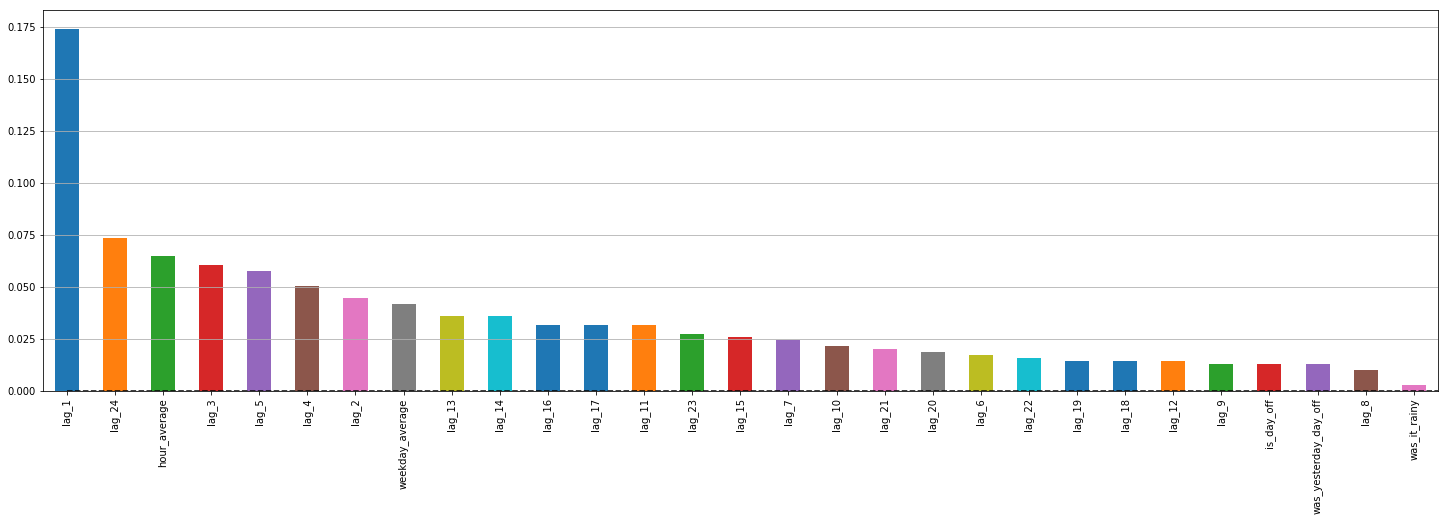

In [50]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plot_model_results(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled)

plot_coefficients(xgb)

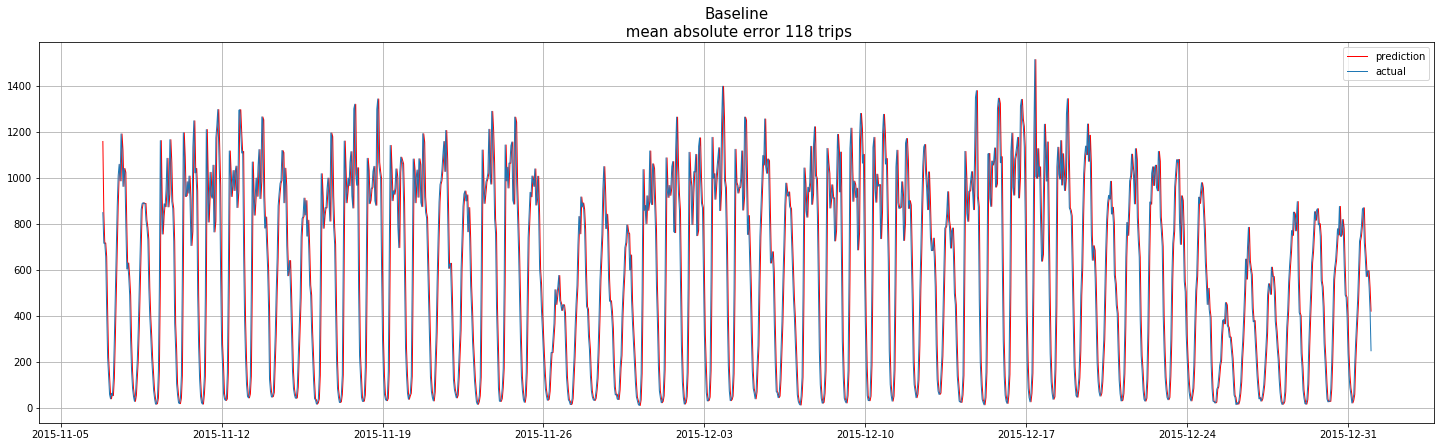

In [51]:
test_value = len(base_prediction) - round(test_size * len(base_prediction))
plt.figure(figsize=(25, 7))
plt.plot(base_prediction[test_value:], 'r', label='prediction', linewidth=1.0)
plt.plot(base_actual[test_value:], label='actual', linewidth=1.0)
plt.legend(loc='best')
plt.title('Baseline\n mean absolute error %i trips'%(int(
    mean_absolute_error(base_actual[test_value:], base_prediction[test_value:]))),size=15)
plt.grid(True)